
Hello this is a Neural network for a trivial task with the mnist dataset

In [20]:
import numpy as np
import struct
from array import array
from os.path  import join
import matplotlib.pyplot as plt


class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
    # Read labels
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        

        # Read images
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())

        images = []
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(rows, cols)  
            images.append(img)

        return images, labels
    
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)       


This section demonstrates how to load the MNIST dataset using a custom data loader, visualize random training and test images, and plot the distribution of digit labels.

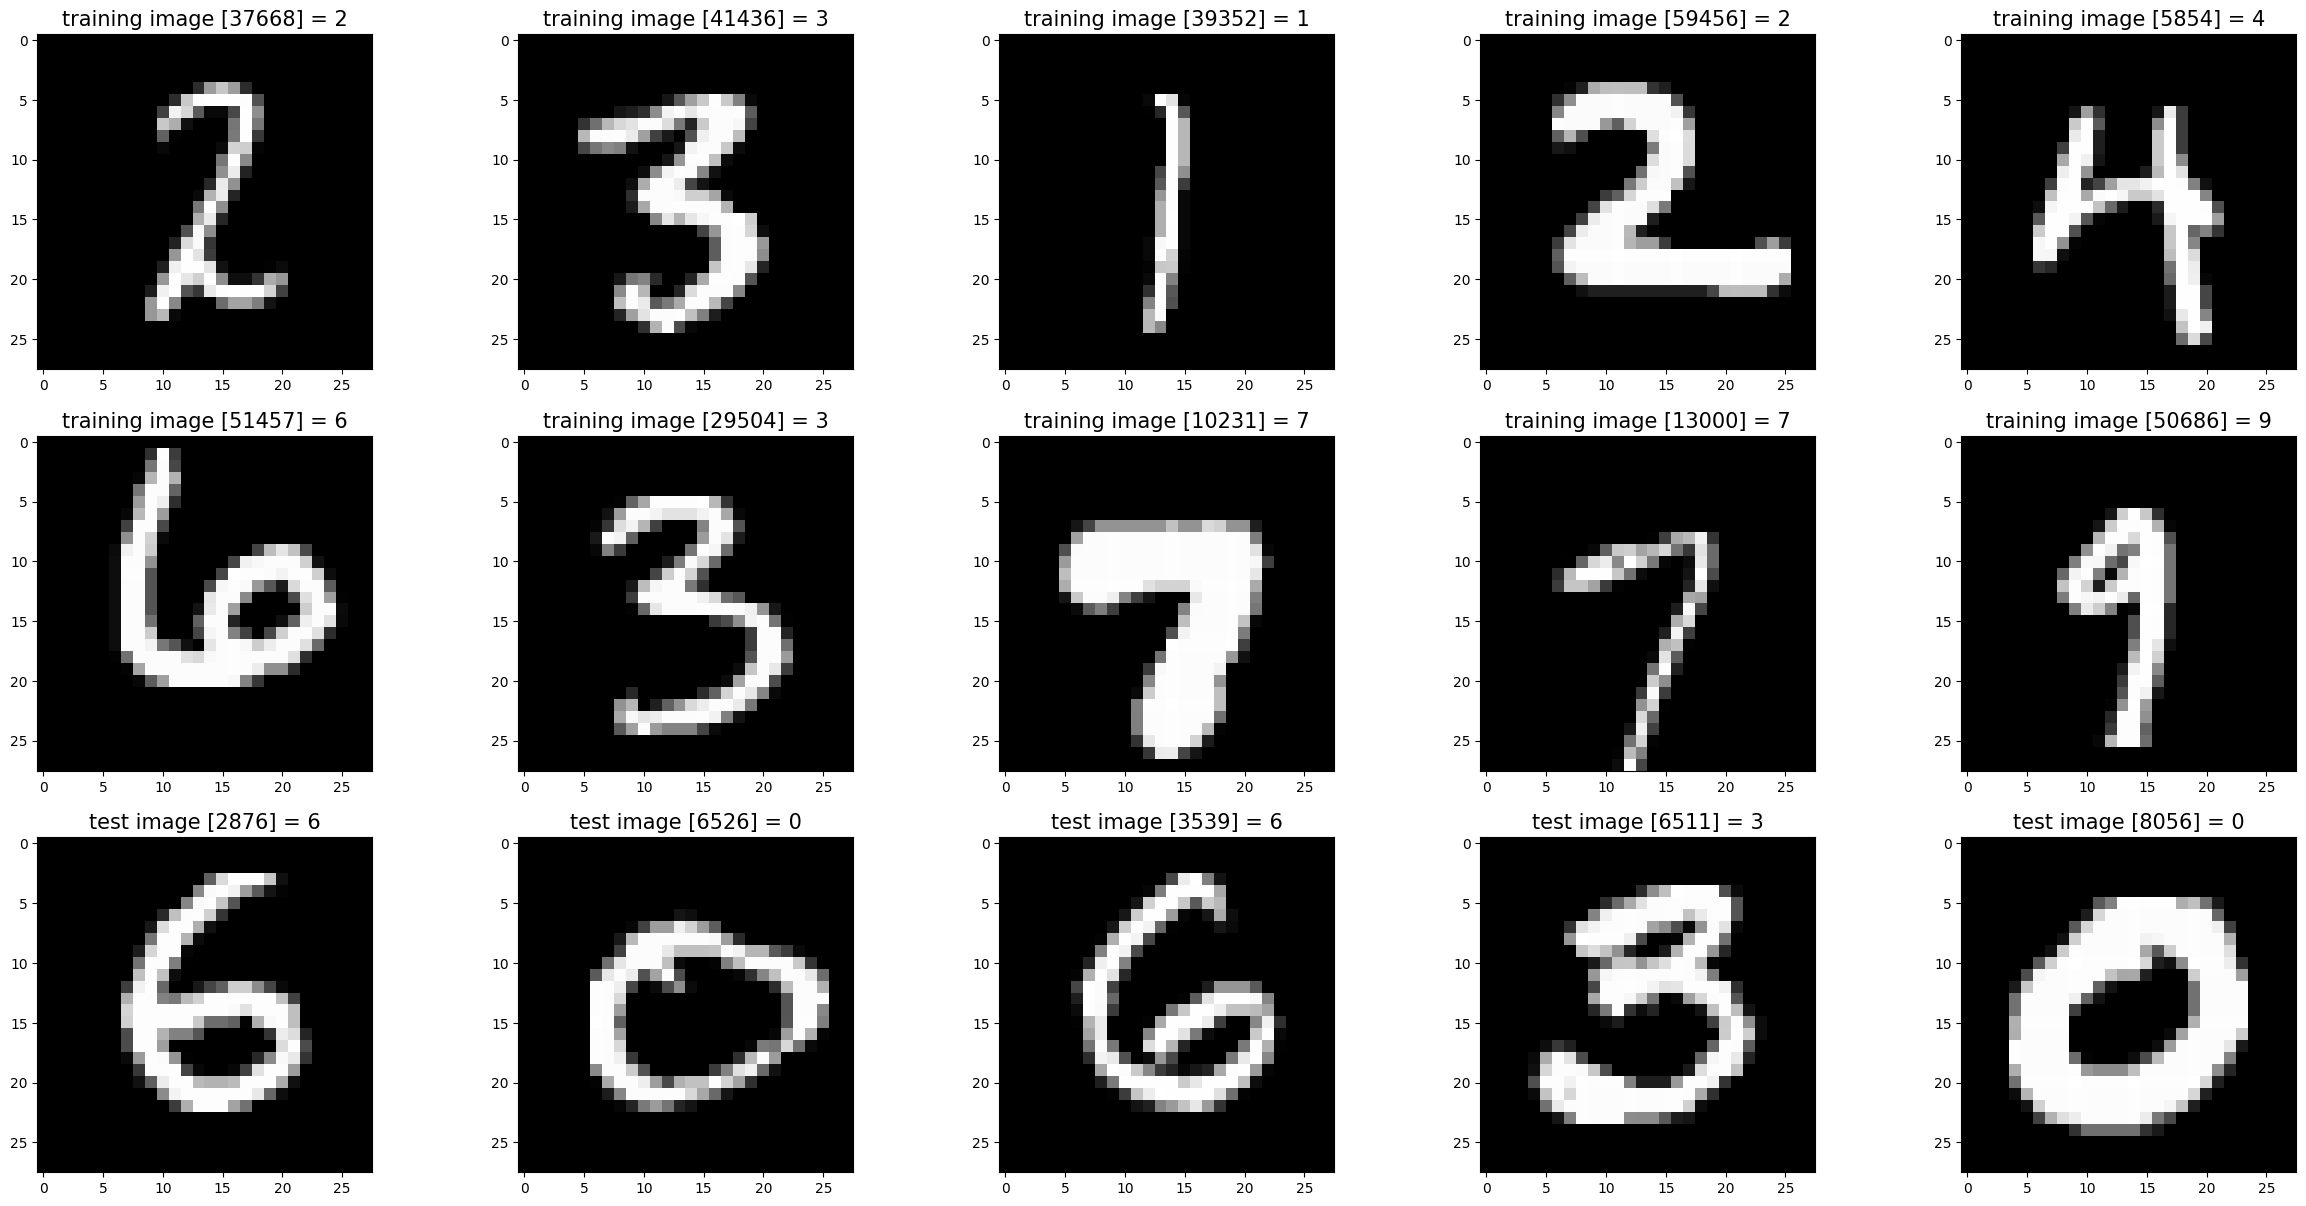

In [21]:
import random
import matplotlib.pyplot as plt # type: ignore


input_path = r'D:\Datasets\mnist' 
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# Help function to show a list of images with their relating titles, mostly for verification

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()


# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

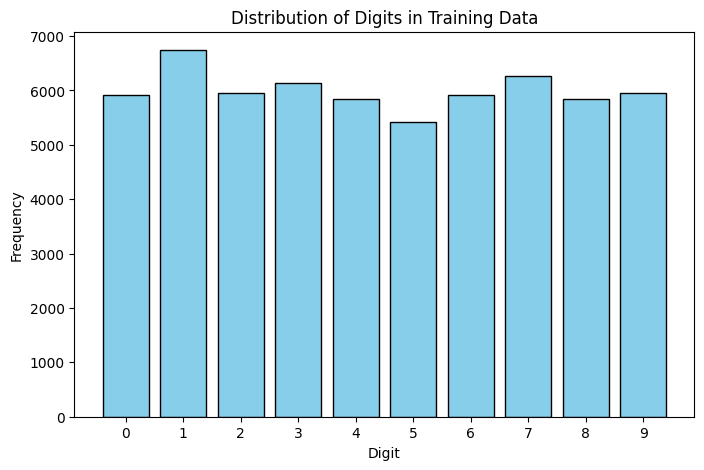

In [22]:
y_train = np.array(y_train)

#frequency of each digit
digits = np.arange(10)
frequency = [np.sum(y_train == d) for d in digits]
#bar graph
plt.figure(figsize=(8, 5))
plt.bar(digits, frequency, color='skyblue', edgecolor='black')
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.title('Distribution of Digits in Training Data')
plt.xticks(digits)
plt.show()

Before training, each MNIST image is normalized and flattened. This is handled by two helper functions:

preprocess_images(images):
Converts a list of 2D images into a 2D NumPy array where each image is flattened (28×28 becomes 784) and the pixel values are normalized to the range [0, 1].

one_hot_encode(labels, num_classes=10):
Converts a list of integer labels into one‑hot encoded vectors. For example, the label 3 becomes [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

In [23]:
def preprocess_images(images):
    num_images = len(images)
    processed = np.zeros((num_images, 28 * 28), dtype = np.float32)

    for i, img in enumerate(images):
        flat_img = img.flatten()
        processed [i, :] = flat_img / 255.0
    return processed
    
x_train_processed = preprocess_images(x_train)
x_test_processed = preprocess_images(x_test)

def one_hot_encode(labels, num_classes=10):
    one_hot = np.zeros((len(labels), num_classes))
    for i, label in enumerate(labels):
        one_hot[i, label] = 1
    return one_hot

The network is implemented from scratch using NumPy. It includes:
Xavier Initialization for the weights.
A sigmoid activation in the hidden layer.
A softmax activation in the output layer to produce class probabilities
Cross-Entropy Loss used during training.
A simple backpropagation routine to update weights and biases.

In [24]:
def relu(x):
    return np.maximum(0, x)
        
def relu_derivative(x):
    return np.where(x > 0, 1, 0)
        

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    # Clip values for numerical stability to avoid log(0)
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1.0 - eps)
    # Compute cross entropy loss for m samples
    m = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred)) / m
    return loss

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Xavier Initialization for weights
        limit_hidden = np.sqrt(6 / (input_size + hidden_size))
        self.weights_hidden_input = np.random.uniform(-limit_hidden, limit_hidden, (input_size, hidden_size))
        limit_output = np.sqrt(6 / (hidden_size + output_size))
        self.weights_hidden_output = np.random.uniform(-limit_output, limit_output, (hidden_size, output_size))
        
        # Add biases
        self.bias_hidden = np.zeros((1, hidden_size))
        self.bias_output = np.zeros((1, output_size))

    def forward(self, x):
        # calculate hidden layer weight
        self.hidden_input = np.dot(x, self.weights_hidden_input) + self.bias_hidden
        self.hidden_output = relu(self.hidden_input)
        
        # calc output
        self.final_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        self.final_output = softmax(self.final_input)
        return self.final_output

    def backward(self, x, y, learning_rate):

        m = y.shape[0]  # number of samples
    
        delta_output = (self.final_output - y) / m

         # Gradients for the output weights and biases
        grad_weights_hidden_output = np.dot(self.hidden_output.T, delta_output)
        grad_bias_output = np.sum(delta_output, axis=0, keepdims=True)
        # Propagate the error to the hidden layer
        delta_hidden = np.dot(delta_output, self.weights_hidden_output.T) * relu_derivative(self.hidden_output)
        
        # Gradients for the hidden weights and biases
        grad_weights_hidden_input = np.dot(x.T, delta_hidden)
        grad_bias_hidden = np.sum(delta_hidden, axis=0, keepdims=True)
        
        # Update weights and biases
        self.weights_hidden_output -= learning_rate * grad_weights_hidden_output
        self.bias_output -= learning_rate * grad_bias_output
        
        self.weights_hidden_input -= learning_rate * grad_weights_hidden_input
        self.bias_hidden -= learning_rate * grad_bias_hidden

    
    def train(self, x_train, y_train, learning_rate, epochs):
        for epoch in range(epochs):
            # Forward pass
            output = self.forward(x_train)
            loss = cross_entropy_loss(y_train, output)
            
            # Backward pass
            self.backward(x_train, y_train, learning_rate)
            
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss:.4f}')
        


In [27]:

#Load MNIST
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, 
                                   test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Preprocess the images: flatten and normalize
x_train_processed = preprocess_images(x_train)
x_test_processed = preprocess_images(x_test)

# One-hot encode labels for the classification (we use 10 because MNIST goes from 0-9)
y_train_encoded = one_hot_encode(y_train, num_classes=10)
y_test_encoded = one_hot_encode(y_test, num_classes=10)

input_size = 28 * 28     # Each image is 28x28 pixels
hidden_size = 256         # might change hidden size
output_size = 10         # 10 classes for digits 0-9

# Instantiate the neural network
nn = NeuralNetwork(input_size, hidden_size, output_size)

# Training hyperparameters
learning_rate = 0.005
epochs = 200

# Start training
nn.train(x_train_processed, y_train_encoded, learning_rate=learning_rate, epochs=epochs)

# See the final predictions on some test data:
test_predictions = nn.forward(x_test_processed)
predicted_labels = np.argmax(test_predictions, axis=1)
print("Sample predicted labels:", predicted_labels[:10])

#return accuracy for each individual class.
def per_class_accuracy(y_true, y_pred, num_classes=10):
    acc_dict = {}
    for cls in range(num_classes):
        cls_idx = (y_true == cls)
        if np.sum(cls_idx) > 0:
            acc = np.sum(y_pred[cls_idx] == cls) / np.sum(cls_idx)
            acc_dict[cls] = acc
        else:
            acc_dict[cls] = None  # In case a class is missing
    return acc_dict

y_true = np.array(y_test)
per_class_acc = per_class_accuracy(y_true, predicted_labels, num_classes=10)

print("Per-Class Accuracies:", per_class_acc)

def f1_multiclass(y_true, y_pred, average='macro'):
    classes = np.unique(y_true)
    f1_scores = {}
    precisions = {}
    recalls = {}

    for cls in classes:
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        f1_scores[cls] = f1
        precisions[cls] = precision
        recalls[cls] = recall
    
    if average == 'macro':
        f1_avg = np.mean(list(f1_scores.values()))
    elif average == 'weighted':
        support = {cls: np.sum(y_true == cls) for cls in classes}
        total = len(y_true)
        f1_avg = sum(f1_scores[cls] * support[cls] for cls in classes) / total
    else:
        raise ValueError("Average must be 'macro' or 'weighted'")
        
    return f1_avg, f1_scores, precisions, recalls

y_true = np.array(y_test)
f1_macro, f1_per_class, precision_per_class, recall_per_class = f1_multiclass(y_true, predicted_labels, average='macro')
print("Macro F1 Score:", f1_macro)



Epoch 0, Loss: 2.4354
Epoch 100, Loss: 1.9449
Sample predicted labels: [7 6 1 0 4 1 8 9 6 4]
Per-Class Accuracies: {0: np.float64(0.95), 1: np.float64(0.9612334801762115), 2: np.float64(0.5465116279069767), 3: np.float64(0.7732673267326733), 4: np.float64(0.7321792260692465), 5: np.float64(0.3071748878923767), 6: np.float64(0.7599164926931107), 7: np.float64(0.7772373540856031), 8: np.float64(0.6663244353182751), 9: np.float64(0.578790882061447)}
Macro F1 Score: 0.696358406861994


In [26]:
def save_model(nn, filename="custom_nn_weights.npz"):
    np.savez(filename,
             weights_hidden_input=nn.weights_hidden_input,
             weights_hidden_output=nn.weights_hidden_output)
    print(f"Model weights saved to {filename}")

# save the weights after training
save_model(nn)

Model weights saved to custom_nn_weights.npz
